# Dependencies

In [1]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
# from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef

from scipy.stats import randint, mode, uniform
# import xgboost as xgb
from xgboost import XGBClassifier

# from copy import deepcopy
import os

In [4]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())

AttributeError: module 'tensorflow' has no attribute '__version__'

# Load Data Sets

In [2]:
train = pd.read_csv('train.csv', header=0, index_col='id')
test = pd.read_csv('test.csv', header=0, index_col='id')

In [13]:
train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [14]:
test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [288]:
train['cap-shape'].value_counts()

cap-shape
x        1436026
f         676238
s         365146
b         318646
o         108835
          ...   
12.62          1
5.15           1
19.04          1
49.21          1
19.06          1
Name: count, Length: 74, dtype: int64

In [337]:
# X = deepcopy(train).drop(['class'], axis=1)
# y = deepcopy(train['class'])

In [3]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, shuffle=True)# , random_state=42)
X_train, y_train = train.drop(['class'], axis=1), train['class']

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2337708 entries, 970478 to 2219110
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   cap-diameter          float64
 1   cap-shape             object 
 2   cap-surface           object 
 3   cap-color             object 
 4   does-bruise-or-bleed  object 
 5   gill-attachment       object 
 6   gill-spacing          object 
 7   gill-color            object 
 8   stem-height           float64
 9   stem-width            float64
 10  stem-root             object 
 11  stem-surface          object 
 12  stem-color            object 
 13  veil-type             object 
 14  veil-color            object 
 15  has-ring              object 
 16  ring-type             object 
 17  spore-print-color     object 
 18  habitat               object 
 19  season                object 
dtypes: float64(3), object(17)
memory usage: 374.5+ MB


In [4]:
num_cols = ['cap-diameter', 'stem-height', 'stem-width']
cat_cols = list(set(X_train.columns) - set(num_cols)) # 18 columns

# cols_w_missing_series = X_train.isnull().sum()
# cols_w_missing = list(cols_w_missing_series[cols_w_missing_series.values != 0].index)

# cat_cols_high_missing = ['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color']
# cat_cols_no_high_missing = list(set(cat_cols) - set(cat_cols_high_missing)) #14

# Define Pipelines

In [5]:
# Redefining 'replace_rare_values' to accept 
def replace_rare_values(X, threshold=0.0001):
    for i in range(X.shape[1]):
        values, counts = np.unique(X[:,i], return_counts=True)
        rare_values = values[counts < threshold*len(X)]
        mode_value = values[np.argmax(counts)]
        X[:,i] = np.where(np.isin(X[:,i], rare_values), mode_value, X[:,i])
    return X

In [6]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    FunctionTransformer(replace_rare_values, validate=False, kw_args={'threshold': 0.001}),
    OneHotEncoder(handle_unknown='ignore'))

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    #('cat', cat_pipeline, cat_cols_no_high_missing)
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

# XGBoost

In [342]:
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('xgb_clf', XGBClassifier(tree_method='hist', random_state=42))
])

In [347]:

xgb_params_dist = {
    # 'xgb_clf__eta': uniform(loc=0, scale=1.0), #best=0.6   
    # 'xgb_clf__lambda': uniform(loc=0, scale=1000)   #best=156
    # 'xgb_clf__max_depth': randint(2, 100), #best=84
    'xgb_clf__eta': uniform(loc=0, scale=1.0), #best=0.485
    'xgb_clf__lambda': uniform(loc=0, scale=200),   #best=90
    'xgb_clf__max_depth': randint(2, 50) #best=42, score:0.979
}

xgb_rnd_srch = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions = xgb_params_dist,
    n_iter = 100,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    random_state=42,
    n_jobs=-1)

# Encode y_train (XGBoost only works with 0/1 and does not accept 'p'/'e' as the target)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train) 
xgb_rnd_srch.fit(X_train[:100_000], y_train_encoded[:100_000]) 

# Use this before predicting <<<<<<<<<<<<<<<
# xgb_clf.get_booster().set_param('predictor', 'gpu_predictor')

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['cap-diameter',
                                                                                'stem-height',
                                                                                'stem-width']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('functiontransformer',
                                                                                                Functio...
                   param_distributions={'xgb_clf__eta': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022AC69BF7F0>,
                                        'xgb_clf__lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022A83D3A5B0>,
                                        'xgb_clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022A83D43520>},
                   random_state=42, return_train_score=True,
                   scoring='matthews_corrcoef')

In [348]:
print(f'best score: {xgb_rnd_srch.best_score_}')
print(f'best params: {xgb_rnd_srch.best_params_}')

best score: 0.9794153664711587
best params: {'xgb_clf__eta': 0.4856137535862266, 'xgb_clf__lambda': 89.68482859724946, 'xgb_clf__max_depth': 42}


* best score: 0.9794
* eta: 0.4856
* lambda: 89.68
* max_depth: 42

In [349]:
xgb_params = [{
    # 'xgb_clf__eta': [0.50, 0.7, 0.75, 0.77, 0.80, 0.85], # best: 0.77
    # 'xgb_clf__lambda': [100, 150, 180, 190, 198, 200, 210], # best: 180
    # 'xgb_clf__max_depth': [20, 40, 60, 80, 85, 89, 90, 95, 100] # best: 40, score: 0.976
    # 'xgb_clf__eta': [0.76, 0.77, 0.78, 0.79], # best: 0.77
    # 'xgb_clf__lambda': [170, 175, 180, 185], # best: 180
    # 'xgb_clf__max_depth': [30, 35, 40, 45, 50] # best: 30
    # 'xgb_clf__eta': [0.76, 0.77, 0.78, 0.79], # best: 0.77
    # 'xgb_clf__lambda': [170, 175, 180, 185], # best: 180
    # 'xgb_clf__max_depth': [20, 25, 30, 33] # best: 30
    ###
    # 'xgb_clf__eta': [0.5, 0.55, 0.6, 0.65, 0.7], # best: 0.60
    # 'xgb_clf__lambda': [140, 150, 156, 160, 170], # best: 170
    # 'xgb_clf__max_depth': [30, 50, 70, 80, 84, 90] # best: 50
    'xgb_clf__eta': [0.45, 0.5, 0.6, 0.7], # best: 0.60
    'xgb_clf__lambda': [90, 120, 156, 160, 170, 180], # best: 170
    'xgb_clf__max_depth': [25, 30, 40, 42, 50, 84 ] # best: 50, score:0.9804
}]

xgb_gsrch = GridSearchCV(
    xgb_pipeline,
    param_grid = xgb_params,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    n_jobs=-1)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train) 
xgb_gsrch.fit(X_train[:200_000], y_train_encoded[:200_000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['cap-diameter',
                                                                          'stem-height',
                                                                          'stem-width']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTrans...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid=[{'xgb_clf__eta': [0.45, 0.5, 0.6, 0.7],
                          'xgb_clf__lambda': [90, 120, 156, 160, 170, 180],
                          'xgb_clf__max_depth': [25, 30, 40, 42, 50, 84]}],
             return_train_score=True, scoring='matthews_corrcoef')

In [350]:
print(f'best score: {xgb_gsrch.best_score_}')
print(f'best params: {xgb_gsrch.best_params_}')

best score: 0.9804388787228498
best params: {'xgb_clf__eta': 0.6, 'xgb_clf__lambda': 180, 'xgb_clf__max_depth': 40}


* best score: 0.9804
* eta: 0.6
* lambda: 180
* max_depth: 40

# MLP

In [ ]:
mlp_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('mlp_clf', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                              learning_rate='adaptive', learning_rate_init=0.001,
                              early_stopping=True, max_iter=10_000, random_state=42))
])

In [ ]:
mlp_params_dist = {
    'mlp_clf__alpha': uniform(loc=0, scale=0.01),
    'mlp_clf__n_iter_no_change': randint(10, 50)
}

mlp_rnd_srch = RandomizedSearchCV(
    mlp_pipeline,
    param_distributions = mlp_params_dist,
    n_iter = 30,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    random_state=42,
    n_jobs=-1)

mlp_rnd_srch.fit(X_train[:50_000], y_train[:50_000])

In [ ]:
print(f'best score: {mlp_rnd_srch.best_score_}')
print(f'best params: {mlp_rnd_srch.best_params_}')

best score: 0.9717985096190641 <br>
best params: {'mlp_clf__alpha': 0.006842330265121569, 'mlp_clf__n_iter_no_change': 16}

In [ ]:
mlp_params = [{
    # 'mlp_clf__alpha': [0.005, 0.0055, 0.0065, 0.0068, 0.0070, 0.0075], # best: 0.005
    # 'mlp_clf__n_iter_no_change': [10, 14, 16, 18, 20] # best: 20, score: 0.97158
    # 'mlp_clf__alpha': [0.0035, 0.0040, 0.0045, 0.005, 0.0055, 0.0065, 0.0068], # best: 0.0035
    # 'mlp_clf__n_iter_no_change': [10, 16, 20, 25, 30] # best: 25, score: 0.97166
    'mlp_clf__alpha': [0.0025, 0.0030, 0.0035, 0.0040, 0.0045], # best: 0.0035
    'mlp_clf__n_iter_no_change': [20, 25, 30] # best: 25, score: 0.97166
}]

mlp_gsrch = GridSearchCV(
    mlp_pipeline,
    param_grid = mlp_params,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    n_jobs=-1)

mlp_gsrch.fit(X_train[500_000:550_000], y_train[500_000:550_000])

In [ ]:
print(f'best score: {mlp_gsrch.best_score_}')
print(f'best params: {mlp_gsrch.best_params_}')

In [ ]:
mlp_pipeline1 = Pipeline([
    ('preprocessing', preprocessing),
    ('mlp_clf', MLPClassifier(activation='relu', solver='adam', 
                              learning_rate='adaptive', learning_rate_init=0.001,
                              early_stopping=True, max_iter=10_000, random_state=42))
])

In [ ]:
mlp_params1 = [{
    'mlp_clf__hidden_layer_sizes': [(100,), (200,), (200, 100), (100, 50)], # best: (100,)
    'mlp_clf__alpha': [0.003, 0.0035, 0.004], # best: 0.0035
    'mlp_clf__n_iter_no_change': [20, 25, 30] # best: 25
}]

mlp_gsrch1 = GridSearchCV(
    mlp_pipeline1,
    param_grid = mlp_params1,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    n_jobs=-1)

mlp_gsrch1.fit(X_train[500_000:550_000], y_train[500_000:550_000])

In [ ]:
print(f'best score: {mlp_gsrch1.best_score_}')
print(f'best params: {mlp_gsrch1.best_params_}')

# Random Forest

In [352]:
rf_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('rf_clf', RandomForestClassifier(criterion='gini', random_state=42, oob_score=True, n_jobs=-1))
])

In [353]:
rf_params_dist = {
    # 'rf_clf__n_estimators': randint(10, 300), # best: 245
    # 'rf_clf__max_depth': randint(2, 100), # best: 81
    # 'rf_clf__criterion': np.random.choice(['gini','entropy'], 1, p=[0.5, 0.5]) # best: 'entropy'
    # 'rf_clf__n_estimators': randint(150, 250), # best: 237
    # 'rf_clf__max_depth': randint(20, 90), # best: 28
    # 'rf_clf__criterion': np.random.choice(['gini','entropy'], 1, p=[0.5, 0.5]) # best: 'gini'   score: 0.977176
    # 'rf_clf__n_estimators': randint(200, 300), # best: 287
    # 'rf_clf__max_depth': randint(20, 80), # best: 30
    # 'rf_clf__criterion': np.random.choice(['gini','entropy'], 1, p=[0.5, 0.5]) # best: 'gini'  score: 0.977136
    ###
    'rf_clf__n_estimators': randint(200, 400), # best: 390
    'rf_clf__max_depth': randint(20, 80), # best: 48, score:0.9809

}

rf_rnd_srch = RandomizedSearchCV(
    rf_pipeline,
    param_distributions = rf_params_dist,
    n_iter = 100,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    random_state=42,
    n_jobs=-1)

rf_rnd_srch.fit(X_train[:100_000], y_train[:100_000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['cap-diameter',
                                                                                'stem-height',
                                                                                'stem-width']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('functiontransformer',
                                                                                                Functio...
                                                                     oob_score=True,
                                                                     random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'rf_clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022AC73232E0>,
                                        'rf_clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022AD3CBFEB0>},
                   random_state=42, return_train_score=True,
                   scoring='matthews_corrcoef')

In [354]:
print(f'best params: {rf_rnd_srch.best_params_}')
print(f'best score: {rf_rnd_srch.best_score_}')

best params: {'rf_clf__max_depth': 48, 'rf_clf__n_estimators': 390}
best score: 0.9809311301489901


* best score=0.9809
* max_depth=48
* n_estimators=390

In [355]:
rf_rnd_srch.best_estimator_['rf_clf'].oob_score_

0.99052

oob score=0.99052

In [356]:
rf_params = [{
    # 'rf_clf__n_estimators': [200, 235, 237, 240, 245, 287, 290], # best: 290
    # 'rf_clf__max_depth': [20, 25, 28, 30, 35, 81], # best:  28, score: 0.977486
    # 'rf_clf__n_estimators': [237, 287, 290, 300, 310], # best: 290
    # 'rf_clf__max_depth': [20, 25, 28, 30, 35], # best:  28, score: 0.977486
    ###
    'rf_clf__n_estimators': [290, 350, 380, 390, 400], # best: 380
    'rf_clf__max_depth': [30, 35, 40, 48, 50], # best: 40 , score:0.9814
}]

rf_gsrch = GridSearchCV(
    rf_pipeline,
    param_grid = rf_params,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    n_jobs=-1)

rf_gsrch.fit(X_train[:200_000], y_train[:200_000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['cap-diameter',
                                                                          'stem-height',
                                                                          'stem-width']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTrans...
                                                                          'gill-color',
                                                                          'cap-color',
                                                                          'cap-shape',
                                                                          'gill-attachment',
                                                                          'season',
                                                                          'habitat',
                                                                          'ring-type',
                                                                          'stem-surface',
                                                                          'stem-color'])])),
                                       ('rf_clf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               oob_score=True,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'rf_clf__max_depth': [30, 35, 40, 48, 50],
                          'rf_clf__n_estimators': [290, 350, 380, 390, 400]}],
             return_train_score=True, scoring='matthews_corrcoef')

In [357]:
print(f'best score: {rf_gsrch.best_score_}')
print(f'best params: {rf_gsrch.best_params_}')

best score: 0.9814498337444846
best params: {'rf_clf__max_depth': 40, 'rf_clf__n_estimators': 380}


* best score: 0.9814
* max_depth: 40
* n_estimators: 380

In [358]:
rf_gsrch.best_estimator_['rf_clf'].oob_score_

0.99084

oob score: 0.9908

# ExtraTrees

In [360]:
xt_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('xt_clf', ExtraTreesClassifier(criterion='gini', bootstrap=True, oob_score=True, random_state=42))
])

In [361]:
xt_params_dist = {
    # 'xt_clf__n_estimators': randint(50, 500), # best: 358
    # 'xt_clf__max_depth': randint(10, 100), # best: 31
    # 'xt_clf__criterion': np.random.choice(['gini','entropy'], 1, p=[0.5, 0.5]) # best: 'gini' score: 0.97277
    # 'xt_clf__n_estimators': randint(200, 400), # best: 389
    # 'xt_clf__max_depth': randint(20, 50), # best: 27 score: 0.97306 
    # 'xt_clf__n_estimators': randint(300, 400), # best: 346
    # 'xt_clf__max_depth': randint(20, 40), # best: 27 score: 0.97314
    ####
    'xt_clf__n_estimators': randint(300, 400), # best: 358
    'xt_clf__max_depth': randint(20, 60), # best: 46, score: 0.9788
}

xt_rnd_srch = RandomizedSearchCV(
    xt_pipeline,
    param_distributions = xt_params_dist,
    n_iter = 100,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    random_state=42,
    n_jobs=-1)

xt_rnd_srch.fit(X_train[:100_000], y_train[:100_000]) 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['cap-diameter',
                                                                                'stem-height',
                                                                                'stem-width']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('functiontransformer',
                                                                                                Functio...
                                                                   oob_score=True,
                                                                   random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'xt_clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022AC2CE62E0>,
                                        'xt_clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022AC69E61F0>},
                   random_state=42, return_train_score=True,
                   scoring='matthews_corrcoef')

In [362]:
print(f'best params: {xt_rnd_srch.best_params_}')
print(f'best score: {xt_rnd_srch.best_score_}')

best params: {'xt_clf__max_depth': 46, 'xt_clf__n_estimators': 358}
best score: 0.9788719740677173


* best score: 0.9788
* max_depth: 46
* n_estimator: 358

In [363]:
xt_rnd_srch.best_estimator_['xt_clf'].oob_score_

0.98951

oob score: 0.9895

In [368]:
xt_params = [{
    # 'xt_clf__n_estimators': [330, 340, 346, 350, 358, 389], # best: 340
    # 'xt_clf__max_depth': [25, 27, 30, 31], # best: 31 score: 0.97384
    # 'xt_clf__criterion': ['gini','entropy']
    # 'xt_clf__n_estimators': [335, 340, 345, 350, 360], # best: 345
    # 'xt_clf__max_depth': [27, 30, 31, 33, 35], # best: 31 score: 0.97384
    ###
    # 'xt_clf__n_estimators': [355, 358, 360, 365], # best:365
    # 'xt_clf__max_depth': [35, 40, 46, 50], # best:35 , score:0.98928
    'xt_clf__n_estimators': [365, 370, 375], # best:365
    'xt_clf__max_depth': [30, 35, 42], # best:35 , score:0.97928
}]

xt_gsrch = GridSearchCV(
    xt_pipeline,
    param_grid = xt_params,
    cv=3,
    # scoring = 'accuracy',
    scoring = 'matthews_corrcoef', # This is specified by competition
    return_train_score=True,
    n_jobs=-1)

xt_gsrch.fit(X_train[:200_000], y_train[:200_000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['cap-diameter',
                                                                          'stem-height',
                                                                          'stem-width']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTrans...
                                                                          'spore-print-color',
                                                                          'gill-color',
                                                                          'cap-color',
                                                                          'cap-shape',
                                                                          'gill-attachment',
                                                                          'season',
                                                                          'habitat',
                                                                          'ring-type',
                                                                          'stem-surface',
                                                                          'stem-color'])])),
                                       ('xt_clf',
                                        ExtraTreesClassifier(bootstrap=True,
                                                             oob_score=True,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid=[{'xt_clf__max_depth': [30, 35, 42],
                          'xt_clf__n_estimators': [365, 370, 375]}],
             return_train_score=True, scoring='matthews_corrcoef')

In [369]:
print(f'best score: {xt_gsrch.best_score_}')
print(f'best params: {xt_gsrch.best_params_}')

best score: 0.9792809175929191
best params: {'xt_clf__max_depth': 35, 'xt_clf__n_estimators': 365}


* best score: 0.97928
* max_depth: 35
* n_estimators: 365

In [370]:
xt_gsrch.best_estimator_['xt_clf'].oob_score_

0.98999

oob score: 0.9899

# Define Base Predictors

In [7]:
rf = RandomForestClassifier(
    n_estimators=380,
    max_depth=40,
    criterion='gini',
    #random_state=42, 
    oob_score=False, 
    n_jobs=25, verbose=1
    )

xt = ExtraTreesClassifier(
    n_estimators=365,
    max_depth=35,
    criterion='gini',
    bootstrap=False, 
    oob_score=False, 
    #random_state=42,
    n_jobs=25, verbose=1
    )

# mlp = MLPClassifier(
#     hidden_layer_sizes=(100,), 
#     activation='relu', 
#     solver='adam', 
#     learning_rate='adaptive',
#     alpha= 0.0035,
#     learning_rate_init=0.001,
#     early_stopping=True, 
#     n_iter_no_change=25,
#     max_iter=10_000, 
#     #random_state=42,
#     verbose=True)

xgb = XGBClassifier(
    tree_method='hist',
    eta=0.6,
    max_depth=40,
    reg_lambda=180,
    #random_state=42,
    verbosity=2)

# xgb_pipeline = ([
#     ('preprocessing', preprocessing),
#     ('xgb', xgb)
# ])

# Voting Classifier (Soft)

## 1. Define Model

In [429]:
import sklearn
print(sklearn.__version__)

1.4.2


In [445]:
import os

max_n_jobs = os.cpu_count()
print(f"Maximum n_jobs available: {max_n_jobs}")

Maximum n_jobs available: 28


In [447]:
import multiprocessing

max_n_jobs = multiprocessing.cpu_count()
print(f"Maximum n_jobs available: {max_n_jobs}")


Maximum n_jobs available: 28


In [8]:
vt_soft = VotingClassifier(
    estimators = [
        ('rf', rf),
        ('xt', xt),
        #('mlp', mlp),
        ('xgb', xgb)
    ], 
    voting='soft'
)

vt_soft_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('vt', vt_soft)
])

Voting Strategy: The VotingClassifier uses either hard voting (majority class voting) or soft voting (average predicted probabilities) to make the final prediction. This decision-making process is not tuned to maximize any specific metric, including MCC.<br>

Scoring during Evaluation: The actual scoring, like MCC, is only applied during the evaluation process (e.g., cross-validation, model selection) when you use a scoring function. However, this evaluation does not influence the voting strategy of the VotingClassifier itself. <br>

If you need to optimize for MCC or any other specific metric, you would typically do this outside the VotingClassifier by selecting or tuning your base models according to that metric. However, the VotingClassifier itself remains agnostic to the metric used during evaluation.<br>

To explicitly maximize MCC, you might consider using a different approach, such as tuning the thresholds for class probabilities or adjusting the contributions of each estimator, but this would require custom implementation beyond the standard VotingClassifier.

## 2. Fit Model

In [9]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

vt_soft_pipeline.fit(X_train, y_train_encoded)

[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed: 30.0min
[Parallel(n_jobs=25)]: Done 380 out of 380 | elapsed: 75.0min finished
[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed: 39.0min
[Parallel(n_jobs=25)]: Done 365 out of 365 | elapsed: 91.0min finished


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function replace...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=40,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                  voting='soft'))])

{
	"name": "OSError",
	"message": "[WinError 87] The parameter is incorrect",
	"stack": "---------------------------------------------------------------------------
_RemoteTraceback                          Traceback (most recent call last)
_RemoteTraceback: 
\"\"\"
Traceback (most recent call last):
  File \"c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\joblib\\externals\\loky\\process_executor.py\", line 370, in _sendback_result
    result_queue.put(
  File \"c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\joblib\\externals\\loky\\backend\\queues.py\", line 233, in put
    self._writer.send_bytes(obj)
  File \"c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\multiprocessing\\connection.py\", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File \"c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\multiprocessing\\connection.py\", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
OSError: [WinError 87] The parameter is incorrect
\"\"\"

The above exception was the direct cause of the following exception:

OSError                                   Traceback (most recent call last)
Cell In[444], line 4
      1 label_encoder = LabelEncoder()
      2 y_train_encoded = label_encoder.fit_transform(y_train)
----> 4 vt_soft_pipeline.fit(X_train, y_train_encoded)

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\sklearn\\base.py:1474, in _fit_context.<locals>.decorator.<locals>.wrapper(estimator, *args, **kwargs)
   1467     estimator._validate_params()
   1469 with config_context(
   1470     skip_parameter_validation=(
   1471         prefer_skip_nested_validation or global_skip_validation
   1472     )
   1473 ):
-> 1474     return fit_method(estimator, *args, **kwargs)

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\sklearn\\pipeline.py:475, in Pipeline.fit(self, X, y, **params)
    473     if self._final_estimator != \"passthrough\":
    474         last_step_params = routed_params[self.steps[-1][0]]
--> 475         self._final_estimator.fit(Xt, y, **last_step_params[\"fit\"])
    477 return self

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\sklearn\\base.py:1474, in _fit_context.<locals>.decorator.<locals>.wrapper(estimator, *args, **kwargs)
   1467     estimator._validate_params()
   1469 with config_context(
   1470     skip_parameter_validation=(
   1471         prefer_skip_nested_validation or global_skip_validation
   1472     )
   1473 ):
-> 1474     return fit_method(estimator, *args, **kwargs)

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\sklearn\\ensemble\\_voting.py:366, in VotingClassifier.fit(self, X, y, sample_weight)
    363 self.classes_ = self.le_.classes_
    364 transformed_y = self.le_.transform(y)
--> 366 return super().fit(X, transformed_y, sample_weight)

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\sklearn\\ensemble\\_voting.py:89, in _BaseVoting.fit(self, X, y, sample_weight)
     83 if self.weights is not None and len(self.weights) != len(self.estimators):
     84     raise ValueError(
     85         \"Number of `estimators` and weights must be equal; got\"
     86         f\" {len(self.weights)} weights, {len(self.estimators)} estimators\"
     87     )
---> 89 self.estimators_ = Parallel(n_jobs=self.n_jobs)(
     90     delayed(_fit_single_estimator)(
     91         clone(clf),
     92         X,
     93         y,
     94         sample_weight=sample_weight,
     95         message_clsname=\"Voting\",
     96         message=self._log_message(names[idx], idx + 1, len(clfs)),
     97     )
     98     for idx, clf in enumerate(clfs)
     99     if clf != \"drop\"
    100 )
    102 self.named_estimators_ = Bunch()
    104 # Uses 'drop' as placeholder for dropped estimators

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\sklearn\\utils\\parallel.py:67, in Parallel.__call__(self, iterable)
     62 config = get_config()
     63 iterable_with_config = (
     64     (_with_config(delayed_func, config), args, kwargs)
     65     for delayed_func, args, kwargs in iterable
     66 )
---> 67 return super().__call__(iterable_with_config)

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\joblib\\parallel.py:2007, in Parallel.__call__(self, iterable)
   2001 # The first item from the output is blank, but it makes the interpreter
   2002 # progress until it enters the Try/Except block of the generator and
   2003 # reaches the first `yield` statement. This starts the asynchronous
   2004 # dispatch of the tasks to the workers.
   2005 next(output)
-> 2007 return output if self.return_generator else list(output)

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\joblib\\parallel.py:1650, in Parallel._get_outputs(self, iterator, pre_dispatch)
   1647     yield
   1649     with self._backend.retrieval_context():
-> 1650         yield from self._retrieve()
   1652 except GeneratorExit:
   1653     # The generator has been garbage collected before being fully
   1654     # consumed. This aborts the remaining tasks if possible and warn
   1655     # the user if necessary.
   1656     self._exception = True

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\joblib\\parallel.py:1754, in Parallel._retrieve(self)
   1747 while self._wait_retrieval():
   1748 
   1749     # If the callback thread of a worker has signaled that its task
   1750     # triggered an exception, or if the retrieval loop has raised an
   1751     # exception (e.g. `GeneratorExit`), exit the loop and surface the
   1752     # worker traceback.
   1753     if self._aborting:
-> 1754         self._raise_error_fast()
   1755         break
   1757     # If the next job is not ready for retrieval yet, we just wait for
   1758     # async callbacks to progress.

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\joblib\\parallel.py:1789, in Parallel._raise_error_fast(self)
   1785 # If this error job exists, immediately raise the error by
   1786 # calling get_result. This job might not exists if abort has been
   1787 # called directly or if the generator is gc'ed.
   1788 if error_job is not None:
-> 1789     error_job.get_result(self.timeout)

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\joblib\\parallel.py:745, in BatchCompletionCallBack.get_result(self, timeout)
    739 backend = self.parallel._backend
    741 if backend.supports_retrieve_callback:
    742     # We assume that the result has already been retrieved by the
    743     # callback thread, and is stored internally. It's just waiting to
    744     # be returned.
--> 745     return self._return_or_raise()
    747 # For other backends, the main thread needs to run the retrieval step.
    748 try:

File c:\\Users\\hkara\\.conda\\envs\\ML\\lib\\site-packages\\joblib\\parallel.py:763, in BatchCompletionCallBack._return_or_raise(self)
    761 try:
    762     if self.status == TASK_ERROR:
--> 763         raise self._result
    764     return self._result
    765 finally:

OSError: [WinError 87] The parameter is incorrect"
}

## 3. Save Model

In [10]:
# Save model
import pickle
pickle_file = "vt_soft_pipeline_model_20240829_100train.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(vt_soft_pipeline, file)
print(f"Model saved as {pickle_file}")

Model saved as vt_soft_pipeline_model_20240829_100train.pkl


## 4. Model Score

In [11]:
y_train_pred_vtsoft = vt_soft_pipeline.predict(X_train)
train_score_vtsoft = matthews_corrcoef(y_true=y_train_encoded, y_pred=y_train_pred_vtsoft)
print(f'train Matthews Corr. Coef.: {train_score_vtsoft}')

# y_val_encoded= label_encoder.transform(y_val)
# y_val_pred_vtsoft = vt_soft_pipeline.predict(X_val)
# val_score_vtsoft = matthews_corrcoef(y_true=y_val_encoded, y_pred=y_val_pred_vtsoft)
# print(f'validation Matthews Corr. Coef.: {val_score_vtsoft}')

[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:    8.3s
[Parallel(n_jobs=25)]: Done 380 out of 380 | elapsed:   20.4s finished
[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:    9.5s
[Parallel(n_jobs=25)]: Done 365 out of 365 | elapsed:   22.3s finished


train Matthews Corr. Coef.: 0.9896643623185507


## 5. Predict `test.csv`

In [12]:
X_test = test #deepcopy(test)
y_test_pred_vtsoft = vt_soft_pipeline.predict(X_test)

[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:    5.3s
[Parallel(n_jobs=25)]: Done 380 out of 380 | elapsed:   13.2s finished
[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:    6.3s
[Parallel(n_jobs=25)]: Done 365 out of 365 | elapsed:   14.4s finished


In [13]:
# Transform back to labels
y_test_pred_vtsoft_labels = label_encoder.inverse_transform(y_test_pred_vtsoft)

vtsoft_predicted_df = pd.DataFrame({
    'id': X_test.index,
    'class': y_test_pred_vtsoft_labels
})

vtsoft_predicted_df.set_index('id', inplace=True)
vtsoft_predicted_df.to_csv('submission_vtsoft_20240829_100train.csv')

print(vtsoft_predicted_df)

        class
id           
3116945     e
3116946     p
3116947     p
3116948     p
3116949     e
...       ...
5194904     p
5194905     p
5194906     p
5194907     e
5194908     e

[2077964 rows x 1 columns]


## 6. Load Model

In [ ]:
# # Option #1
# import joblib
# joblib_file = "vt_pipeline_model_1.pkl"
# vt_pipeline_loaded = joblib.load(joblib_file)

# # Option #2
# import pickle
# pickle_file = "vt_pipeline_model_2.pkl"
# with open(pickle_file, 'rb') as file:
#     vt_pipeline_loaded = pickle.load(file)

# Voting Classifier (Hard)

## 1. Define Model

In [ ]:
# vt_hard = VotingClassifier(
#     estimators = [
#         ('rf', rf),
#         ('xt', xt),
#         ('mlp', mlp),
#         ('xgb', xgb)
#     ], voting='hard'
# )

# vt_hard_pipeline = Pipeline([
#     ('preprocessing', preprocessing),
#     ('vt', vt_hard)
# ])

## 1.1. Read Pre-Trained Base Predictors

In [112]:
# Assuming vt_soft is already fitted
import pickle
model_file_path = 'vt_soft_pipeline_model.pkl'
with open(model_file_path, 'rb') as file:
    model = pickle.load(file)
fitted_estimators = model.named_steps['vt'].estimators_


In [115]:
fitted_estimators[0]

RandomForestClassifier(max_depth=28, n_estimators=290, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=1)

In [118]:
# Create the StackingClassifier using the fitted estimators
vt_hard = VotingClassifier(
    estimators=[
        ('rf', fitted_estimators[0]), # 'rf'
        ('xt', fitted_estimators[1]), # 'xt'
        ('mlp', fitted_estimators[2]), # 'mlp'
        ('xgb', fitted_estimators[3]) # 'xgb'
    ], voting='hard'
)

vt_hard_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('vt', vt_hard)
])

## 2. Fit Model

In [125]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

vt_hard_pipeline.fit(X_train, y_train_encoded)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed: 26.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed: 35.3min finished


Iteration 1, loss = 0.07083714
Validation score: 0.988117
Iteration 2, loss = 0.05206383
Validation score: 0.988694
Iteration 3, loss = 0.05078640
Validation score: 0.988600
Iteration 4, loss = 0.05006607
Validation score: 0.989130
Iteration 5, loss = 0.04957790
Validation score: 0.989220
Iteration 6, loss = 0.04930470
Validation score: 0.989113
Iteration 7, loss = 0.04903549
Validation score: 0.988895
Iteration 8, loss = 0.04880660
Validation score: 0.989340
Iteration 9, loss = 0.04863382
Validation score: 0.989301
Iteration 10, loss = 0.04852356
Validation score: 0.989053
Iteration 11, loss = 0.04842701
Validation score: 0.989357
Iteration 12, loss = 0.04826282
Validation score: 0.989438
Iteration 13, loss = 0.04825492
Validation score: 0.989250
Iteration 14, loss = 0.04812211
Validation score: 0.989387
Iteration 15, loss = 0.04807725
Validation score: 0.989413
Iteration 16, loss = 0.04803936
Validation score: 0.989408
Iteration 17, loss = 0.04796899
Validation score: 0.989092
Iterat

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function replace...
                                                             feature_types=None,
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=30,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))]))])

## 3. Save Model

In [128]:
# Save model
import pickle
pickle_file = "vt_hard_pipeline_model_.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(vt_hard_pipeline, file)
print(f"Model saved as {pickle_file}")

PicklingError: Can't pickle <function replace_rare_values at 0x0000022A983EF790>: it's not the same object as __main__.replace_rare_values

## 4. Model Score

In [131]:
y_train_pred_vthard = vt_hard_pipeline.predict(X_train)
train_score_vthard = matthews_corrcoef(y_true=y_train_encoded, y_pred=y_train_pred_vthard)
print(f'train Matthews Corr. Coef.: {train_score_vthard}')

y_val_encoded= label_encoder.transform(y_val)
y_val_pred_vthard = vt_hard_pipeline.predict(X_val)
val_score_vthard = matthews_corrcoef(y_true=y_val_encoded, y_pred=y_val_pred_vthard)
print(f'validation Matthews Corr. Coef.: {val_score_vthard}')

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    3.7s
[Parallel(n_jobs=28)]: Done 290 out of 290 | elapsed:    6.8s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    4.8s
[Parallel(n_jobs=28)]: Done 345 out of 345 | elapsed:   10.6s finished


train Matthews Corr. Coef.: 0.9867449303657903


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    1.1s
[Parallel(n_jobs=28)]: Done 290 out of 290 | elapsed:    2.1s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    1.4s
[Parallel(n_jobs=28)]: Done 345 out of 345 | elapsed:    3.4s finished


validation Matthews Corr. Coef.: 0.9817563050595514


## 5. Predict `test.csv`

In [129]:
X_test = deepcopy(test)
y_test_pred_vthard = vt_hard_pipeline.predict(X_test)

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    3.3s
[Parallel(n_jobs=28)]: Done 290 out of 290 | elapsed:    6.1s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    4.2s
[Parallel(n_jobs=28)]: Done 345 out of 345 | elapsed:    9.4s finished


In [132]:
# Transform back to labels
y_test_pred_vthard_labels = label_encoder.inverse_transform(y_test_pred_vthard)

vthard_predicted_df = pd.DataFrame({
    'id': X_test.index,
    'class': y_test_pred_vthard_labels
})

vthard_predicted_df.set_index('id', inplace=True)
vthard_predicted_df.to_csv('submission_vthard.csv')

print(vthard_predicted_df)

        class
id           
3116945     e
3116946     p
3116947     p
3116948     p
3116949     e
...       ...
5194904     p
5194905     p
5194906     p
5194907     e
5194908     e

[2077964 rows x 1 columns]


## 6. Load Model

In [ ]:
# # Option #1
# import joblib
# joblib_file = "vthard_pipeline_model.pkl"
# vthard_pipeline_loaded = joblib.load(joblib_file)

# # Option #2
# import pickle
# pickle_file = "vthard_pipeline_model.pkl"
# with open(pickle_file, 'rb') as file:
#     vthard_pipeline_loaded = pickle.load(file)

# Stacking Classifier (Final: Random Forest)

## 1. Define Model

In [ ]:
# st_rf = StackingClassifier(
#     estimators = [
#         ('rf', rf),
#         ('xt', xt),
#         ('mlp', mlp),
#         ('xgb', xgb)
#     ],
#     final_estimator = RandomForestClassifier(
#         n_estimators=100,
#         max_depth=20,
#         random_state=43)
# )

# st_rf_pipeline = Pipeline([
#     ('preprocessing', preprocessing),
#     ('st_rf', st_rf)
# ])

Instead of fitting the stacking classifier from scratch, I use the paitted predictors of the `vt_soft` for the `st_rf` to save time on training.

In [142]:
import pickle
model_file_path = 'vt_soft_pipeline_model.pkl'
with open(model_file_path, 'rb') as file:
    model = pickle.load(file)
fitted_estimators = model.named_steps['vt'].estimators_

In [143]:
# Create the StackingClassifier using the fitted estimators
st_rf = StackingClassifier(
    estimators=[
        ('rf', fitted_estimators[0]),
        ('xt', fitted_estimators[1]),
        #('mlp', fitted_estimators[2]),
        ('xgb', fitted_estimators[3])
    ],
    final_estimator=RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=43)
)

# Pipeline with the StackingClassifier
st_rf_pipeline = Pipeline([
    ('preprocessing', preprocessing),  # Assuming the same preprocessing is used
    ('st_rf', st_rf)
])


## 2. Fit Model

In [144]:
X_train.shape

(2337708, 20)

In [145]:
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

# st_rf_pipeline.fit(X_train, y_train_encoded)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

st_rf_pipeline.fit(X_train[:1_150_000], y_train_encoded[:1_150_000])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed: 10.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 345 out of 345 | elapsed: 13.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  7.1min finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.2s
[Parallel(n_jobs=28)]: Done 290 out of 290 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  3.9

KeyboardInterrupt: 

## 3. Save Model

In [139]:
# Save model
import pickle
pickle_file = "st_rf_pipeline_model.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(st_rf_pipeline, file)
print(f"Model saved as {pickle_file}")

Model saved as st_rf_pipeline_model.pkl


## 4. Model Score

In [140]:
y_train_pred_strf = st_rf_pipeline.predict(X_train)
train_score_strf = matthews_corrcoef(y_true=y_train_encoded, y_pred=y_train_pred_strf)
print(f'train Matthews Corr. Coef.: {train_score_strf}')

y_val_encoded= label_encoder.transform(y_val)
y_val_pred_strf = st_rf_pipeline.predict(X_val)
val_score_strf = matthews_corrcoef(y_true=y_val_encoded, y_pred=y_val_pred_strf)
print(f'validation Matthews Corr. Coef.: {val_score_strf}')

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    1.7s
[Parallel(n_jobs=28)]: Done 290 out of 290 | elapsed:    3.3s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    1.8s
[Parallel(n_jobs=28)]: Done 345 out of 345 | elapsed:    4.0s finished


train Matthews Corr. Coef.: 0.9785475489587885


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.5s
[Parallel(n_jobs=28)]: Done 290 out of 290 | elapsed:    1.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.5s
[Parallel(n_jobs=28)]: Done 345 out of 345 | elapsed:    1.3s finished


validation Matthews Corr. Coef.: 0.9783655432376


## 5. Predict `test.csv`

In [ ]:
X_test = deepcopy(test)
y_test_pred_strf = st_rf_pipeline.predict(X_test)

In [ ]:
# Transform back to labels
y_test_pred_strf_labels = label_encoder.inverse_transform(y_test_pred_strf)

strf_predicted_df = pd.DataFrame({
    'id': X_test.index,
    'class': y_test_pred_strf_labels
})

strf_predicted_df.set_index('id', inplace=True)
strf_predicted_df.to_csv('submission_strf.csv')

print(strf_predicted_df)

## 6. Load Model

In [ ]:
# # Option #1
# import joblib
# joblib_file = "strf_pipeline_model.pkl"
# strf_pipeline_loaded = joblib.load(joblib_file)

# # Option #2
# import pickle
# pickle_file = "strf_pipeline_model.pkl"
# with open(pickle_file, 'rb') as file:
#     strf_pipeline_loaded = pickle.load(file)

# DNN

## 1. Import Dependencies

In [381]:
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Normalization, StringLookup, CategoryEncoding
from tensorflow.keras import layers

Num GPUs Available:  0


## 2. Load Datasets

In [ ]:
train = pd.read_csv('train.csv', header=0, index_col='id')
test = pd.read_csv('test.csv', header=0, index_col='id')

In [382]:
X = deepcopy(train).drop(['class'], axis=1)
y = deepcopy(train['class'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [383]:
num_cols = ['cap-diameter', 'stem-height', 'stem-width']
cat_cols = list(set(X_train.columns) - set(num_cols)) # 18 columns

cols_w_missing_series = X_train.isnull().sum()
cols_w_missing = list(cols_w_missing_series[cols_w_missing_series.values != 0].index)

cat_cols_high_missing = ['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color']
cat_cols_no_high_missing = list(set(cat_cols) - set(cat_cols_high_missing)) #14

## 3. Preprocessing

In [160]:
# # Define numerical feature columns
# num_feature_columns = [tf.feature_column.numeric_column(col) for col in num_cols]

# # Define categorical feature columns
# cat_feature_columns = [tf.feature_column.categorical_column_with_vocabulary_list(col, 
#     X_train[col].dropna().unique()) for col in cat_cols_no_high_missing]

# # Create categorical columns with embeddings
# cat_feature_columns_with_embeddings = [
#     tf.feature_column.embedding_column(categorical_column, dimension=10)  # Adjust dimension as needed
#     for categorical_column in cat_feature_columns
# ]

# # Create the complete feature columns list
# feature_columns = num_feature_columns + cat_feature_columns_with_embeddings

# #################################

# # Define preprocessing function
# def preprocess_fn(features):
#     # Impute missing values for numerical columns with mean
#     for col in num_cols:
#         features[col] = tf.where(tf.math.is_nan(features[col]),
#                                  tf.reduce_mean(features[col]),
#                                  features[col])
    
#     # Replace rare values with mode for categorical columns
#     for col in cat_cols_no_high_missing:
#         values, counts = tf.unique(features[col])
#         counts = tf.math.bincount(tf.cast(tf.argmax(counts), tf.int32))
#         mode_value = values[tf.argmax(counts)]
#         features[col] = tf.where(tf.reduce_any(tf.equal(features[col], values), axis=0),
#                                  features[col],
#                                  mode_value)
#     return features


# ################################


# # Convert DataFrame to TensorFlow Dataset
# def df_to_dataset(features, labels, batch_size=32):
#     dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
#     dataset = dataset.map(lambda x, y: (preprocess_fn(x), y))
#     dataset = dataset.shuffle(buffer_size=len(features)).batch(batch_size)
#     dataset = dataset.prefetch(batch_size)
#     return dataset


# #################################


# # Convert to TensorFlow Dataset
# train_dataset = df_to_dataset(X_train, y_train)
# val_dataset = df_to_dataset(X_val, y_val)


In [ ]:
# def preprocess_data(df): 
#     # Impute missing values for numerical columns with mean
#     for col in num_cols:
#         df[col] = df[col].fillna(df[col].mean())
#     # Normalize numerical columns
#     scaler = StandardScaler()
#     df[num_cols] = scaler.fit_transform(df[num_cols])
    
    
#     # Handle rare values and impute missing values in categorical columns
#     for col in cat_cols_no_high_missing:
#         # Impute missing values with mode
#         cat_imputer = SimpleImputer(strategy='most_frequent')
#         df[col] = cat_imputer.fit_transform(df[[col]]).ravel()
#         # Get value counts and calculate frequencies
#         value_counts = df[col].value_counts()
#         freq = value_counts / len(df[col])    
#         # Determine the rare values based on the threshold
#         rare_values = freq[freq < 0.001].index
#         # Replace rare values with the mode
#         mode_value = df[col].mode()[0]
#         df[col] = df[col].replace(rare_values, mode_value)
    
#     return df


# def df_to_dataset(features, labels, batch_size=32):
#     features = preprocess_data(features)
    
#     # Convert DataFrame to dict
#     features_dict = {col: tf.convert_to_tensor(features[col].values) for col in features.columns}
    
#     # Convert to TensorFlow Dataset
#     dataset = tf.data.Dataset.from_tensor_slices((features_dict, tf.convert_to_tensor(labels.values)))
#     dataset = dataset.shuffle(buffer_size=len(features)).batch(batch_size)
#     dataset = dataset.prefetch(buffer_size=batch_size)
#     return dataset


# # Convert to TensorFlow Dataset
# train_dataset = df_to_dataset(X_train, y_train)
# val_dataset = df_to_dataset(X_val, y_val)


In [ ]:
# label_encoder = LabelEncoder()
# # Encode labels (i.e., 'p' and 'e') to numerical values
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_val_encoded = label_encoder.transform(y_val)
# # Convert to categorical (for use in classification task)
# y_train_encoded = to_categorical(y_train_encoded)
# y_val_encoded = to_categorical(y_val_encoded)

In [ ]:
# def df_to_dataset(X, y, shuffle=True, batch_size=32):
#     dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
#     if shuffle:
#         dataset = dataset.shuffle(buffer_size=len(X))
#     dataset = dataset.batch(batch_size)
#     return dataset

# # Create TensorFlow datasets
# train_dataset = df_to_dataset(X_train, y_train_encoded)
# val_dataset = df_to_dataset(X_val, y_val_encoded, shuffle=False)

In [203]:
# X_train_preprocessed = preprocessing.fit_transform(X_train)
# X_train_dense = X_train_preprocessed.toarray()
# X_train_encoded = tf.convert_to_tensor(X_train_dense, dtype=np.float32)

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

In [ ]:
# print(f'X_train_encoded:\n type: {type(X_train_encoded)}\n shape: {X_train_encoded.shape}\n')
# print(f'y_train_encoded:\n type: {type(y_train_encoded)}\n shape: {y_train_encoded.shape}')

In [224]:
# X_val_preprocessed = preprocessing.transform(X_val)
# X_val_dense = X_val_preprocessed.toarray()
# X_val_encoded = tf.convert_to_tensor(X_val_dense)

# y_val_encoded = label_encoder.transform(y_val)

In [ ]:
# print(f'X_val_encoded:\n type: {type(X_val_encoded)}\n shape: {X_val_encoded.shape}\n')
# print(f'y_val_encoded:\n type: {type(y_val_encoded)}\n shape: {y_val_encoded.shape}')

__Check for Hidden Objects:__<br>
Sometimes, the error might be due to hidden objects in the arrays. To catch these, you can iterate through the arrays and check each element’s type:

In [ ]:
# for i, x in enumerate(X_train_encoded):
#     if not isinstance(x, (float, np.float32, np.float64)):
#         print(f"Non-float data at index {i}: {type(x)}")

# for i, y in enumerate(y_train_encoded):
#     if not isinstance(y, (int, np.int32, np.int64, float, np.float32, np.float64)):
#         print(f"Non-numeric data at index {i}: {type(y)}")


The output indicates that each element in the array is a `numpy.ndarray` rather than a single float. This likely means that your X_train_encoded (and possibly other arrays) is not a 2D array but rather a 1D array of arrays (i.e., a nested array).

__Ensure Your Data is Properly Shaped:__ Convert your data into a 2D array where each row is a sample and each column is a feature.

In [16]:
# X_train_encoded = np.array([x.flatten() for x in X_train_encoded])
# y_train_encoded = np.array(y_train_encoded).flatten()
# X_val_encoded = np.array([x.flatten() for x in X_val_encoded])
# y_val_encoded = np.array(y_val_encoded).flatten()

In [18]:
# X_train_encoded = np.vstack(X_train_encoded)
# X_val_encoded = np.vstack(X_val_encoded)


In [ ]:
# print(X_train_encoded.shape)  # Should be (number_of_samples, number_of_features)
# print(y_train_encoded.shape)  # Should be (number_of_samples,)
# print(X_val_encoded.shape)
# print(y_val_encoded.shape)


In [ ]:
# print(X_train_encoded.dtype)
# print(y_train_encoded.dtype)
# print(X_val_encoded.dtype)
# print(y_val_encoded.dtype)

Elements of Numpy array must be of these compatible types:

* `float32` for features
* `int` or `float32` for labels

In [ ]:
# X_train_encoded = X_train_encoded.astype(np.float32)
# y_train_encoded = y_train_encoded.astype(np.int32)  # or np.float32 if appropriate
# X_val_encoded = X_val_encoded.astype(np.float32)
# y_val_encoded = y_val_encoded.astype(np.int32)  # or np.float32 if appropriate

Check if there is any NaN or Inf values

In [ ]:
# print(np.any(np.isnan(X_train_encoded)))
# print(np.any(np.isnan(y_train_encoded)))
# print(np.any(np.isnan(X_val_encoded)))
# print(np.any(np.isnan(y_val_encoded)))

# print(np.any(np.isinf(X_train_encoded)))
# print(np.any(np.isinf(y_train_encoded)))
# print(np.any(np.isinf(X_val_encoded)))
# print(np.any(np.isinf(y_val_encoded)))


In [384]:
# Ensure the data is a dense matrix (if it was sparse) and convert to float32
X_train_dense = preprocessing.fit_transform(X_train).toarray().astype(np.float32)

# Convert to TensorFlow tensor
X_train_encoded = tf.convert_to_tensor(X_train_dense)

# Check for any non-float data types
for i, x in enumerate(X_train_encoded.numpy().flatten()):
    if not isinstance(x, (float, np.float32, np.float64)):
        print(f"Non-float data at index {i}: {type(x)}")


In [292]:
# Ensure the data is a dense matrix (if it was sparse) and convert to float32
X_val_dense = preprocessing.transform(X_val).toarray().astype(np.float32)

# Convert to TensorFlow tensor
X_val_encoded = tf.convert_to_tensor(X_val_dense)

# Check for any non-float data types
for i, x in enumerate(X_val_encoded.numpy().flatten()):
    if not isinstance(x, (float, np.float32, np.float64)):
        print(f"Non-float data at index {i}: {type(x)}")


In [293]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [294]:
X_train_encoded.shape

TensorShape([2337708, 116])

In [275]:
def matthews_correlation_coefficient(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn) - (fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [229]:
dnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dnn.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[matthews_correlation_coefficient])

In [230]:
dnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               11776     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________


In [231]:
history = dnn.fit(X_train_encoded, y_train_encoded, epochs=10, validation_data=(X_val_encoded, y_val_encoded))

Epoch 1/10
73054/73054 [==============================] - 77s 1ms/step - loss: 0.0557 - matthews_correlation_coefficient: 0.9725 - val_loss: 0.0473 - val_matthews_correlation_coefficient: 0.9776
Epoch 2/10
73054/73054 [==============================] - 75s 1ms/step - loss: 0.0472 - matthews_correlation_coefficient: 0.9780 - val_loss: 0.0458 - val_matthews_correlation_coefficient: 0.9788
Epoch 3/10
73054/73054 [==============================] - 75s 1ms/step - loss: 0.0460 - matthews_correlation_coefficient: 0.9787 - val_loss: 0.0453 - val_matthews_correlation_coefficient: 0.9789
Epoch 4/10
73054/73054 [==============================] - 75s 1ms/step - loss: 0.0452 - matthews_correlation_coefficient: 0.9789 - val_loss: 0.0448 - val_matthews_correlation_coefficient: 0.9793
Epoch 5/10
73054/73054 [==============================] - 74s 1ms/step - loss: 0.0448 - matthews_correlation_coefficient: 0.9792 - val_loss: 0.0450 - val_matthews_correlation_coefficient: 0.9790
Epoch 6/10
73054/73054 [=

In [236]:
dnn_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dnn_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[matthews_correlation_coefficient])

In [237]:
dnn_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               47104     
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 112,897
Trainable params: 112,897
Non-trainable params: 0
_________________________________________________________________


In [238]:
history_2 = dnn_2.fit(X_train_encoded, y_train_encoded, epochs=20, validation_data=(X_val_encoded, y_val_encoded))

Epoch 1/20
73054/73054 [==============================] - 96s 1ms/step - loss: 0.0511 - matthews_correlation_coefficient: 0.9762 - val_loss: 0.0467 - val_matthews_correlation_coefficient: 0.9788
Epoch 2/20
73054/73054 [==============================] - 96s 1ms/step - loss: 0.0461 - matthews_correlation_coefficient: 0.9791 - val_loss: 0.0458 - val_matthews_correlation_coefficient: 0.9797
Epoch 3/20
73054/73054 [==============================] - 95s 1ms/step - loss: 0.0455 - matthews_correlation_coefficient: 0.9795 - val_loss: 0.0449 - val_matthews_correlation_coefficient: 0.9800
Epoch 4/20
73054/73054 [==============================] - 95s 1ms/step - loss: 0.0450 - matthews_correlation_coefficient: 0.9798 - val_loss: 0.0450 - val_matthews_correlation_coefficient: 0.9798
Epoch 5/20
73054/73054 [==============================] - 95s 1ms/step - loss: 0.0451 - matthews_correlation_coefficient: 0.9800 - val_loss: 0.0485 - val_matthews_correlation_coefficient: 0.9789
Epoch 6/20
73054/73054 [=

In [295]:
dnn_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='leaky_relu', input_shape=(X_train_encoded.shape[1],)),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dnn_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[matthews_correlation_coefficient])

dnn_3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 512)               59904     
                                                                 
 dense_57 (Dense)            (None, 128)               65664     
                                                                 
 dense_58 (Dense)            (None, 1)                 129       
                                                                 
Total params: 125,697
Trainable params: 125,697
Non-trainable params: 0
_________________________________________________________________


In [296]:
history_3 = dnn_3.fit(X_train_encoded, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_val_encoded, y_val_encoded))

Epoch 1/30
73054/73054 [==============================] - 94s 1ms/step - loss: 0.0498 - matthews_correlation_coefficient: 0.9765 - val_loss: 0.0454 - val_matthews_correlation_coefficient: 0.9793
Epoch 2/30
73054/73054 [==============================] - 94s 1ms/step - loss: 0.0440 - matthews_correlation_coefficient: 0.9803 - val_loss: 0.0455 - val_matthews_correlation_coefficient: 0.9800
Epoch 3/30
73054/73054 [==============================] - 94s 1ms/step - loss: 0.0431 - matthews_correlation_coefficient: 0.9809 - val_loss: 0.0448 - val_matthews_correlation_coefficient: 0.9806
Epoch 4/30
73054/73054 [==============================] - 94s 1ms/step - loss: 0.0426 - matthews_correlation_coefficient: 0.9811 - val_loss: 0.0426 - val_matthews_correlation_coefficient: 0.9810
Epoch 5/30
73054/73054 [==============================] - 94s 1ms/step - loss: 0.0423 - matthews_correlation_coefficient: 0.9813 - val_loss: 0.0418 - val_matthews_correlation_coefficient: 0.9815
Epoch 6/30
73054/73054 [=

In [420]:
class MetricLearningRateTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        self.train_metrics = []
        self.val_metrics = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr.numpy()
        self.learning_rates.append(lr)
        self.train_metrics.append(logs['matthews_correlation_coefficient'])
        self.val_metrics.append(logs['val_matthews_correlation_coefficient'])

# Define the step decay function
def step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return schedule

# Initialize the metric learning rate tracker
metric_lr_tracker = MetricLearningRateTracker()

# Create the step decay schedule callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay_schedule(initial_lr=0.005, decay_factor=0.5, step_size=10))

In [421]:
dnn_4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='leaky_relu', input_shape=(X_train_encoded.shape[1],)),
    # tf.keras.layers.Reshape((512, 1)),
    # tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, activation='leaky_relu'),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dnn_4.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[matthews_correlation_coefficient])

dnn_4.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 512)               59904     
                                                                 
 dense_94 (Dense)            (None, 128)               65664     
                                                                 
 dense_95 (Dense)            (None, 1)                 129       


                                                                 
Total params: 125,697
Trainable params: 125,697
Non-trainable params: 0
_________________________________________________________________


In [422]:
history_4 = dnn_4.fit(X_train_encoded[:500000], y_train_encoded[:500000], 
                      epochs=50, batch_size=32, 
                      validation_data=(X_val_encoded[:300000], y_val_encoded[:300000]),
                      callbacks=[lr_scheduler, metric_lr_tracker])

Epoch 1/50
15625/15625 [==============================] - 23s 1ms/step - loss: 0.0700 - matthews_correlation_coefficient: 0.9650 - val_loss: 0.0563 - val_matthews_correlation_coefficient: 0.9754 - lr: 0.0050
Epoch 2/50
15625/15625 [==============================] - 22s 1ms/step - loss: 0.0575 - matthews_correlation_coefficient: 0.9740 - val_loss: 0.0521 - val_matthews_correlation_coefficient: 0.9767 - lr: 0.0050
Epoch 3/50
15625/15625 [==============================] - 23s 1ms/step - loss: 0.0550 - matthews_correlation_coefficient: 0.9755 - val_loss: 0.0651 - val_matthews_correlation_coefficient: 0.9700 - lr: 0.0050
Epoch 4/50
15625/15625 [==============================] - 22s 1ms/step - loss: 0.0540 - matthews_correlation_coefficient: 0.9765 - val_loss: 0.0549 - val_matthews_correlation_coefficient: 0.9767 - lr: 0.0050
Epoch 5/50
15625/15625 [==============================] - 23s 1ms/step - loss: 0.0527 - matthews_correlation_coefficient: 0.9768 - val_loss: 0.0537 - val_matthews_corre

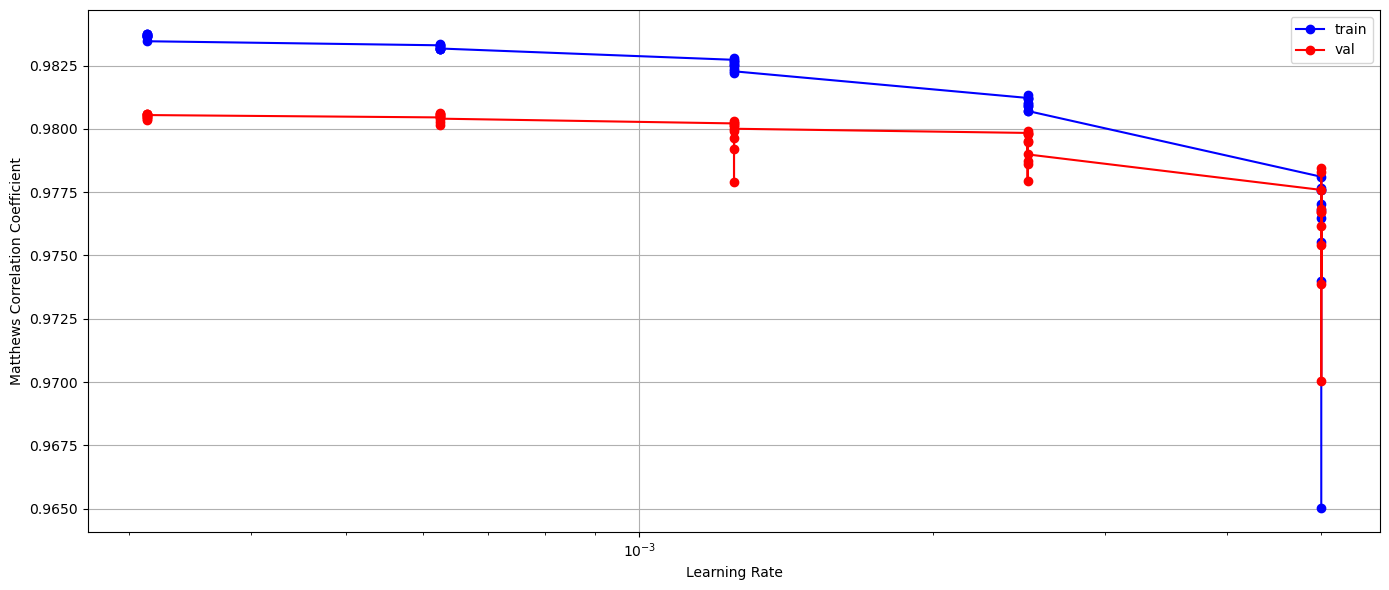

In [423]:
# Plot training and validation metrics vs learning rate
plt.figure(figsize=(14, 6))


plt.plot(metric_lr_tracker.learning_rates, metric_lr_tracker.train_metrics, marker='o', color='b', label='train')
plt.plot(metric_lr_tracker.learning_rates, metric_lr_tracker.val_metrics, marker='o', color='r', label='val')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Matthews Correlation Coefficient')
plt.xscale('log')


plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Save Model

### Save Entire Model

In [297]:
# Save the entire model to a file
# dnn.save('dnn_model_128.h5')
# dnn_2.save('dnn_model_512_128.h5')
dnn_3.save('dnn_model_128_128.h5')


# To load the model later
# loaded_model = tf.keras.models.load_model('dnn_model_128.h5')


### Save Only Model Architecture and Weights to JSON

In [ ]:
# # Save model architecture to JSON
# with open('dnn_model_architecture.json', 'w') as f:
#     f.write(model.to_json())

# # Save weights
# model.save_weights('dnn_model_weights.h5')

# # To load the model architecture and weights later
# from tensorflow.keras.models import model_from_json

# # Load model architecture
# with open('dnn_model_architecture.json', 'r') as f:
#     model_json = f.read()
# model = model_from_json(model_json)

# # Load weights
# model.load_weights('dnn_model_weights.h5')


### Save Only Model Architecture and Weights to YAML

In [ ]:
# # Save model architecture to YAML
# with open('dnn_model_architecture.yaml', 'w') as f:
#     f.write(model.to_yaml())

# # Save weights
# model.save_weights('dnn_model_weights.h5')

# # To load the model architecture and weights later
# from tensorflow.keras.models import model_from_yaml

# # Load model architecture
# with open('dnn_model_architecture.yaml', 'r') as f:
#     model_yaml = f.read()
# model = model_from_yaml(model_yaml)

# # Load weights
# model.load_weights('dnn_model_weights.h5')


### Save and Load with TensorFlow's SaveModel Format

The SavedModel format is TensorFlow’s native format and includes the model’s architecture, weights, and training configuration.

In [ ]:
# # Save the model in SavedModel format
# model.save('dnn_model_directory')

# # To load the model later
# loaded_model = tf.keras.models.load_model('dnn_model_directory')


### Save Model Weight Only

In [ ]:
# # Save weights
# model.save_weights('dnn_model_weights.h5')

# # To load weights into a model with the same architecture
# model.load_weights('dnn_model_weights.h5')


## 5. Prediction

In [299]:
X_test = deepcopy(test)

# Ensure the data is a dense matrix (if it was sparse) and convert to float32
X_test_dense = preprocessing.transform(X_test).toarray().astype(np.float32)

# Convert to TensorFlow tensor
X_test_encoded = tf.convert_to_tensor(X_test_dense)

# Check for any non-float data types
for i, x in enumerate(X_test_encoded.numpy().flatten()):
    if not isinstance(x, (float, np.float32, np.float64)):
        print(f"Non-float data at index {i}: {type(x)}")

In [300]:
y_test_pred_dnn3 = dnn_3.predict(X_test_encoded)

64937/64937 [==============================] - 43s 668us/step


In [301]:
type(y_test_pred_dnn3)

numpy.ndarray

In [302]:
y_test_pred_dnn3.shape

(2077964, 1)

In [305]:
y_test_pred_dnn3[:5]

array([[0.0030094 ],
       [0.99938   ],
       [0.9946937 ],
       [0.9990101 ],
       [0.00253923]], dtype=float32)

In [328]:
y_test_pred_dnn3_classes = (y_test_pred_dnn3>0.5).astype(int)

In [329]:
y_test_pred_dnn3_classes

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [330]:
y_test_pred_dnn3_classes.shape

(2077964, 1)

In [332]:
lb=label_encoder.inverse_transform(y_test_pred_dnn3_classes.ravel())
lb.shape

(2077964,)

In [334]:
# Transform back to labels
y_test_pred_dnn3_labels = label_encoder.inverse_transform(y_test_pred_dnn3_classes.ravel())

dnn3_predicted_df = pd.DataFrame({
    'id': X_test.index,
    'class': y_test_pred_dnn3_labels
})

dnn3_predicted_df.set_index('id', inplace=True)
dnn3_predicted_df.to_csv('submission_dnn3.csv')

print(dnn3_predicted_df)

        class
id           
3116945     e
3116946     p
3116947     p
3116948     p
3116949     e
...       ...
5194904     p
5194905     p
5194906     p
5194907     e
5194908     e

[2077964 rows x 1 columns]
